In [2]:
%pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
   ----- ---------------------------------- 2.4/16.5 MB 9.5 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/16.5 MB 11.3 MB/s eta 0:00:02
   -------------------- ------------------- 8.4/16.5 MB 13.1 MB/s eta 0:00:01
   -------------------------- ------------- 11.0/16.5 MB 12.8 MB/s eta 0:00:01
   ---------------------------------- ----- 14.4/16.5 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 13.6 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list

Package                           Version
--------------------------------- --------------------
aiobotocore                       2.25.0
aiodns                            3.5.0
aiohappyeyeballs                  2.6.1
aiohttp                           3.13.2
aioitertools                      0.12.0
aiosignal                         1.4.0
alabaster                         0.7.16
altair                            5.5.0
anaconda-anon-usage               0.7.5
anaconda-auth                     0.12.0
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.7.0
anaconda-client                   1.14.0
anaconda-navigator                2.7.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.10.0
appdirs                           1.4.4
archspec                          0.2.5
argon2-cffi                       21.3.0
argon2-cffi-bindings              25.1.0
arrow                             1.4.0
astroid      

In [7]:
%pip install pandas mysql-connector-python sqlalchemy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pymysql

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Cell 2 – Database Config
DB_HOST    = "localhost"
DB_PORT    = 3306
DB_USER    = "root"
DB_PASS    = "Subha@@5092"
DB_NAME    = "digital_prescription_db"
BATCH_SIZE = 1000

In [8]:

patients      = pd.read_csv('patients_1000.csv')
doctors       = pd.read_csv('doctors_1000.csv')
medicines     = pd.read_csv('medicines_1000.csv')
prescriptions = pd.read_csv('prescriptions_1000.csv')

raw_prescriptions = prescriptions.copy()

print("Patients :", patients.shape)
print("Doctors  :", doctors.shape)
print("Medicines:", medicines.shape)
print("Rx       :", prescriptions.shape)

Patients : (1000, 5)
Doctors  : (1000, 4)
Medicines: (1000, 3)
Rx       : (1000, 7)


In [9]:

patients = patients.drop_duplicates().copy()
patients['patient_id']   = patients['patient_id'].astype(str).str.strip()
patients['patient_name'] = patients['patient_name'].astype(str).str.strip()

patients['gender'] = patients['gender'].astype(str).str.upper().str.strip()
patients['gender'] = patients['gender'].apply(
    lambda x: x[0] if x and x[0] in ['M', 'F'] else 'U'
)

before = len(patients)
patients['age'] = pd.to_numeric(patients['age'], errors='coerce')
patients = patients[(patients['age'] >= 0) & (patients['age'] <= 100)].copy()
patients['age'] = patients['age'].astype(int)

print(f"Removed {before - len(patients)} patient(s) with invalid age")
print(f"Remaining patients: {len(patients)}")

Removed 512 patient(s) with invalid age
Remaining patients: 488


In [10]:

doctors = doctors.drop_duplicates().copy()
doctors['doctor_id']   = doctors['doctor_id'].astype(str).str.strip()
doctors['doctor_name'] = doctors['doctor_name'].astype(str).str.strip()

medicines = medicines.drop_duplicates().copy()
medicines['medicine_id']   = medicines['medicine_id'].astype(str).str.strip()
medicines['medicine_name'] = medicines['medicine_name'].astype(str).str.strip()

print("Doctors  :", len(doctors))
print("Medicines:", len(medicines))

Doctors  : 1000
Medicines: 1000


In [11]:

pre_dup = len(prescriptions)
prescriptions = prescriptions.drop_duplicates(subset=['prescription_id'], keep=False).copy()
print(f"Duplicates removed: {pre_dup - len(prescriptions)}")

prescriptions['prescription_id'] = prescriptions['prescription_id'].astype(str).str.strip()
prescriptions['patient_id']      = prescriptions['patient_id'].astype(str).str.strip()
prescriptions['doctor_id']       = prescriptions['doctor_id'].astype(str).str.strip()
prescriptions['medicine_id']     = prescriptions['medicine_id'].astype(str).str.strip()

prescriptions['dosage'] = (prescriptions['dosage']
                           .fillna('Not Provided')
                           .replace(r'^\s*$', 'Not Provided', regex=True))

prescriptions['frequency'] = (prescriptions['frequency']
                               .fillna('Not Provided')
                               .replace(r'^\s*$', 'Not Provided', regex=True))

prescriptions['prescribed_date'] = pd.to_datetime(
    prescriptions['prescribed_date'], errors='coerce'
).dt.date
prescriptions = prescriptions[prescriptions['prescribed_date'].notna()].copy()

valid_patients  = set(patients['patient_id'])
valid_doctors   = set(doctors['doctor_id'])
valid_medicines = set(medicines['medicine_id'])

pre_fk = len(prescriptions)
prescriptions = prescriptions[
    prescriptions['patient_id'].isin(valid_patients) &
    prescriptions['doctor_id'].isin(valid_doctors)   &
    prescriptions['medicine_id'].isin(valid_medicines)
].copy()

print(f"Rejected (invalid FK): {pre_fk - len(prescriptions)}")
print(f"Clean prescriptions  : {len(prescriptions)}")

Duplicates removed: 0
Rejected (invalid FK): 537
Clean prescriptions  : 463


In [12]:

def df_to_rows(df, columns):
    temp = df[columns].copy()
    temp = temp.replace({np.nan: None})
    temp = temp.where(pd.notnull(temp), None)
    return temp.values.tolist()

patient_rows      = df_to_rows(patients,      ['patient_id','patient_name','gender','age','contact_no'])
doctor_rows       = df_to_rows(doctors,       ['doctor_id','doctor_name','specialization','hospital_name'])
medicine_rows     = df_to_rows(medicines,     ['medicine_id','medicine_name','category'])
prescription_rows = df_to_rows(prescriptions, ['prescription_id','patient_id','doctor_id',
                                                'medicine_id','dosage','frequency','prescribed_date'])

conn   = pymysql.connect(host=DB_HOST, port=DB_PORT, user=DB_USER,
                         password=DB_PASS, database=DB_NAME, autocommit=False)
cursor = conn.cursor()

def batch_insert(query, rows):
    for i in range(0, len(rows), BATCH_SIZE):
        cursor.executemany(query, rows[i:i+BATCH_SIZE])

patient_q = """
    INSERT INTO patients (patient_id,patient_name,gender,age,contact_no)
    VALUES (%s,%s,%s,%s,%s)
    ON DUPLICATE KEY UPDATE
        patient_name=VALUES(patient_name), gender=VALUES(gender),
        age=VALUES(age), contact_no=VALUES(contact_no)"""

doctor_q = """
    INSERT INTO doctors (doctor_id,doctor_name,specialization,hospital_name)
    VALUES (%s,%s,%s,%s)
    ON DUPLICATE KEY UPDATE
        doctor_name=VALUES(doctor_name), specialization=VALUES(specialization),
        hospital_name=VALUES(hospital_name)"""

medicine_q = """
    INSERT INTO medicines (medicine_id,medicine_name,category)
    VALUES (%s,%s,%s)
    ON DUPLICATE KEY UPDATE
        medicine_name=VALUES(medicine_name), category=VALUES(category)"""

prescription_q = """
    INSERT INTO prescriptions
        (prescription_id,patient_id,doctor_id,medicine_id,dosage,frequency,prescribed_date)
    VALUES (%s,%s,%s,%s,%s,%s,%s)
    ON DUPLICATE KEY UPDATE
        dosage=VALUES(dosage), frequency=VALUES(frequency),
        prescribed_date=VALUES(prescribed_date)"""

try:
    batch_insert(patient_q,      patient_rows)
    batch_insert(doctor_q,       doctor_rows)
    batch_insert(medicine_q,     medicine_rows)
    batch_insert(prescription_q, prescription_rows)
    conn.commit()
    print("Data inserted successfully.")
except Exception as e:
    conn.rollback()
    print("Error:", e)
finally:
    cursor.close()
    conn.close()

Data inserted successfully.


In [13]:

try:
    idx_conn   = pymysql.connect(host=DB_HOST, port=DB_PORT, user=DB_USER,
                                 password=DB_PASS, database=DB_NAME, autocommit=True)
    idx_cursor = idx_conn.cursor()

    indexes = [
        ("idx_prescribed_date", "CREATE INDEX idx_prescribed_date ON prescriptions(prescribed_date)"),
        ("idx_doctor_id",       "CREATE INDEX idx_doctor_id       ON prescriptions(doctor_id)"),
        ("idx_medicine_id",     "CREATE INDEX idx_medicine_id     ON prescriptions(medicine_id)"),
    ]

    for name, ddl in indexes:
        try:
            idx_cursor.execute(ddl)
            print(f"Index created : {name}")
        except pymysql.err.OperationalError as e:
            if e.args[0] == 1061:
                print(f"Already exists: {name}")
            else:
                raise
except Exception as e:
    print("Index error:", e)
finally:
    idx_cursor.close()
    idx_conn.close()

Already exists: idx_prescribed_date
Already exists: idx_doctor_id
Already exists: idx_medicine_id


In [14]:
# Cell 8 – Create Analytics Indexes
try:
    idx_conn   = pymysql.connect(host=DB_HOST, port=DB_PORT, user=DB_USER,
                                 password=DB_PASS, database=DB_NAME, autocommit=True)
    idx_cursor = idx_conn.cursor()

    indexes = [
        ("idx_prescribed_date", "CREATE INDEX idx_prescribed_date ON prescriptions(prescribed_date)"),
        ("idx_doctor_id",       "CREATE INDEX idx_doctor_id       ON prescriptions(doctor_id)"),
        ("idx_medicine_id",     "CREATE INDEX idx_medicine_id     ON prescriptions(medicine_id)"),
    ]

    for name, ddl in indexes:
        try:
            idx_cursor.execute(ddl)
            print(f"Index created : {name}")
        except pymysql.err.OperationalError as e:
            if e.args[0] == 1061:
                print(f"Already exists: {name}")
            else:
                raise
except Exception as e:
    print("Index error:", e)
finally:
    idx_cursor.close()
    idx_conn.close()

Already exists: idx_prescribed_date
Already exists: idx_doctor_id
Already exists: idx_medicine_id


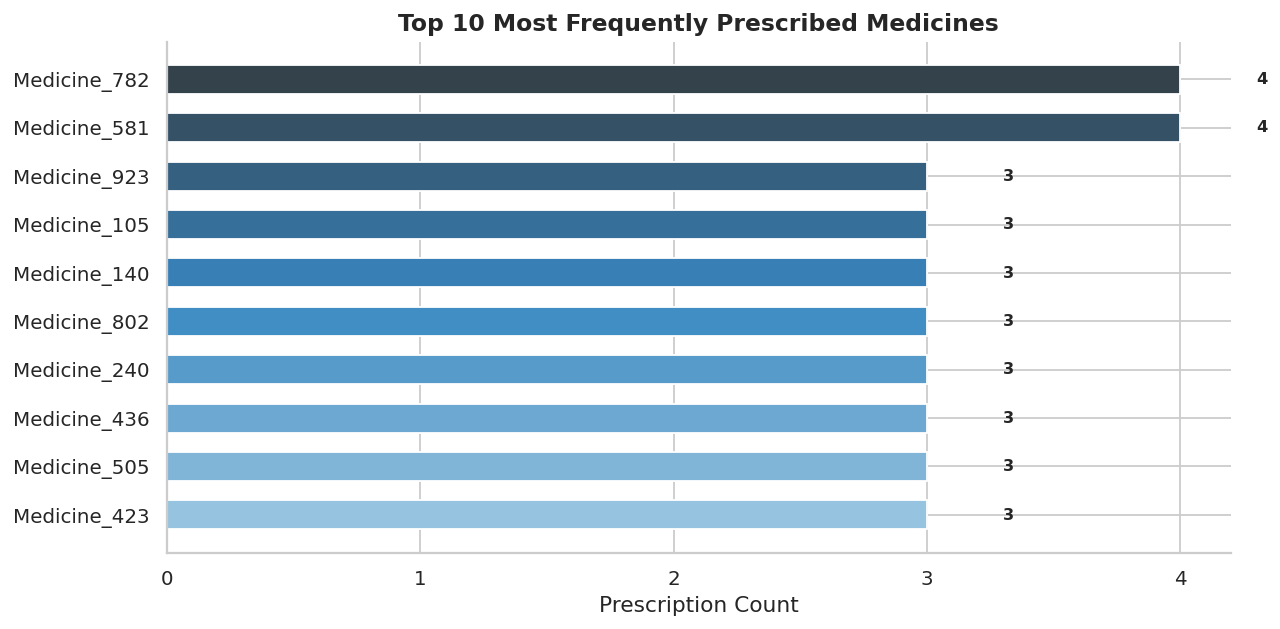

In [15]:
# Cell 10 – Insight 1: Top 10 Prescribed Medicines
top_meds = rx['medicine_name'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(top_meds.index[::-1], top_meds.values[::-1],
               color=sns.color_palette("Blues_d", 10), height=0.6)

for bar, val in zip(bars, top_meds.values[::-1]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', fontsize=9, fontweight='bold')

ax.set_xlabel("Prescription Count")
ax.set_title("Top 10 Most Frequently Prescribed Medicines", fontsize=13, fontweight='bold')
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
sns.despine()
plt.tight_layout()
plt.savefig("insight1_top_medicines.png")
plt.show()

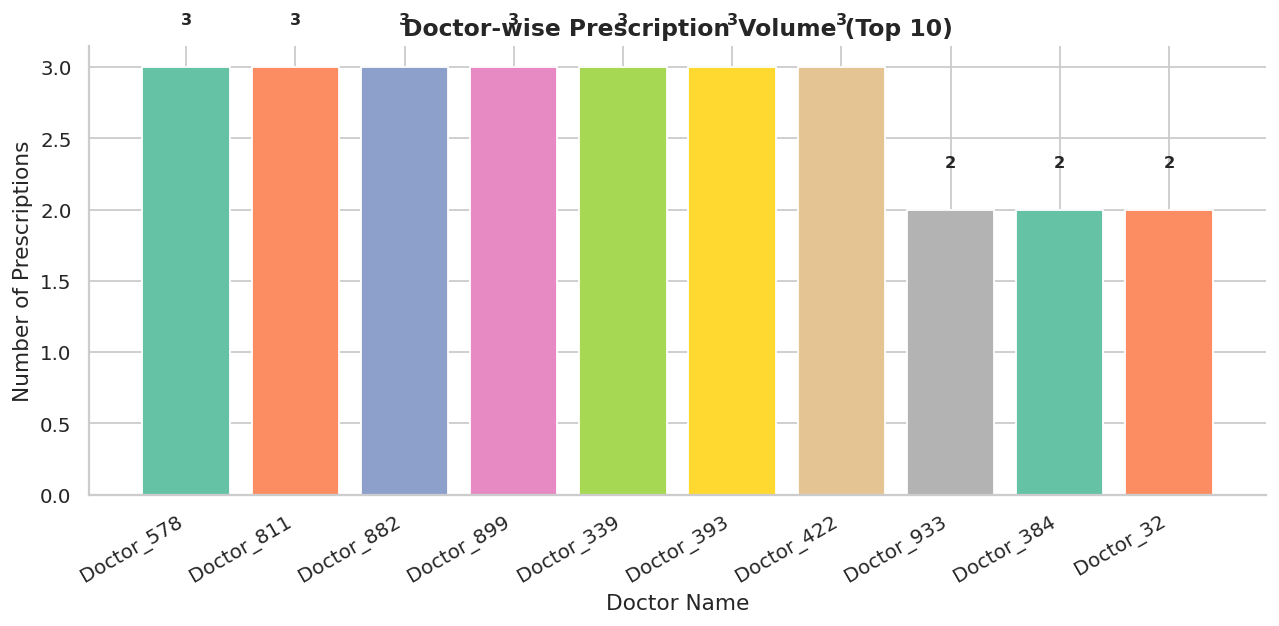

In [16]:
# Cell 11 – Insight 2: Doctor-wise Prescription Volume
doc_vol = rx['doctor_name'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(doc_vol.index, doc_vol.values,
       color=sns.color_palette("Set2", len(doc_vol)), edgecolor='white')

for i, val in enumerate(doc_vol.values):
    ax.text(i, val + 0.3, str(val), ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel("Doctor Name")
ax.set_ylabel("Number of Prescriptions")
ax.set_title("Doctor-wise Prescription Volume (Top 10)", fontsize=13, fontweight='bold')
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.savefig("insight2_doctor_volume.png")
plt.show()

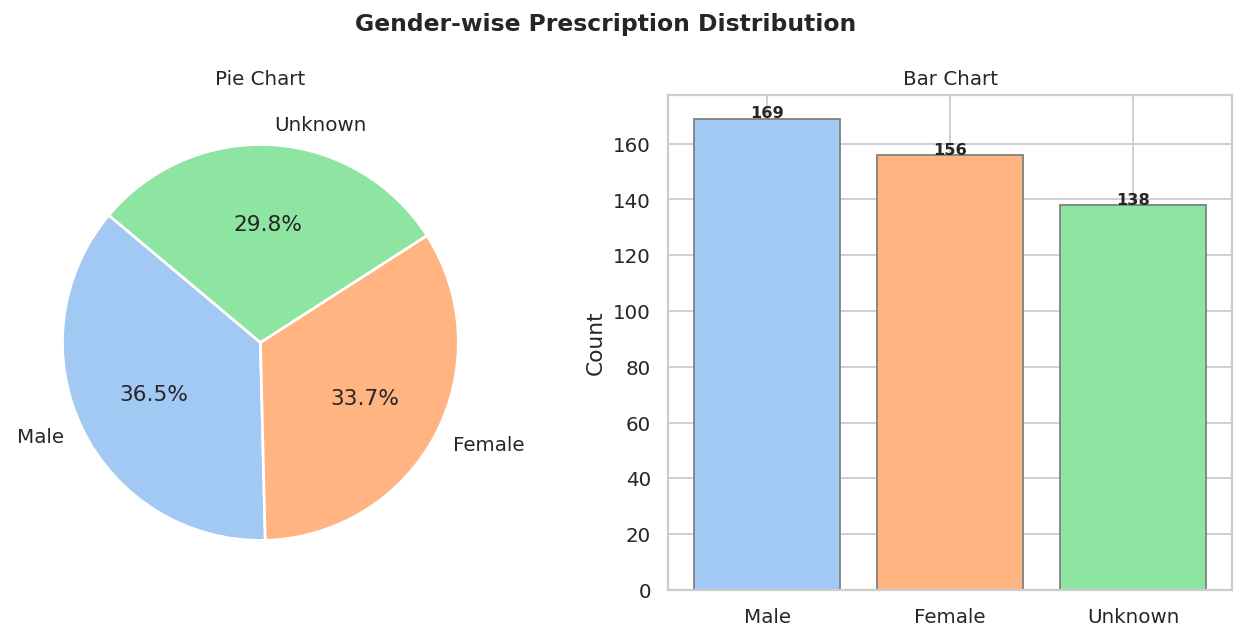

In [17]:
# Cell 12 – Insight 3: Gender-wise Distribution
gender_counts = rx['gender'].value_counts()
gender_labels = {'M': 'Male', 'F': 'Female', 'U': 'Unknown'}
mapped        = [gender_labels.get(g, g) for g in gender_counts.index]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(gender_counts.values, labels=mapped, autopct='%1.1f%%',
            colors=sns.color_palette("pastel"), startangle=140,
            wedgeprops=dict(edgecolor='white', linewidth=1.5))
axes[0].set_title("Pie Chart", fontsize=11)

axes[1].bar(mapped, gender_counts.values,
            color=sns.color_palette("pastel"), edgecolor='grey')
for i, val in enumerate(gender_counts.values):
    axes[1].text(i, val + 0.3, str(val), ha='center', fontsize=9, fontweight='bold')
axes[1].set_ylabel("Count")
axes[1].set_title("Bar Chart", fontsize=11)

fig.suptitle("Gender-wise Prescription Distribution", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("insight3_gender_distribution.png")
plt.show()

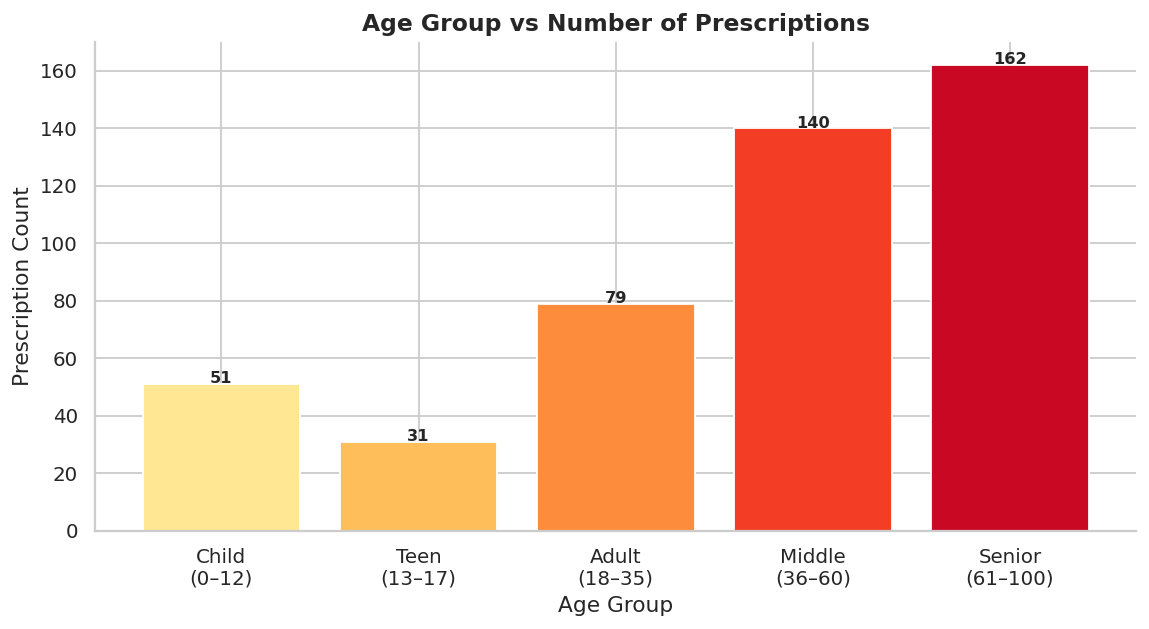

In [18]:
# Cell 13 – Insight 4: Age Group vs Prescriptions
age_grp = rx['age_group'].value_counts().reindex(labels)

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(age_grp.index, age_grp.values,
       color=sns.color_palette("YlOrRd", len(labels)), edgecolor='white')

for i, val in enumerate(age_grp.values):
    ax.text(i, val + 0.3, str(val), ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel("Age Group")
ax.set_ylabel("Prescription Count")
ax.set_title("Age Group vs Number of Prescriptions", fontsize=13, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.savefig("insight4_age_group.png")
plt.show()

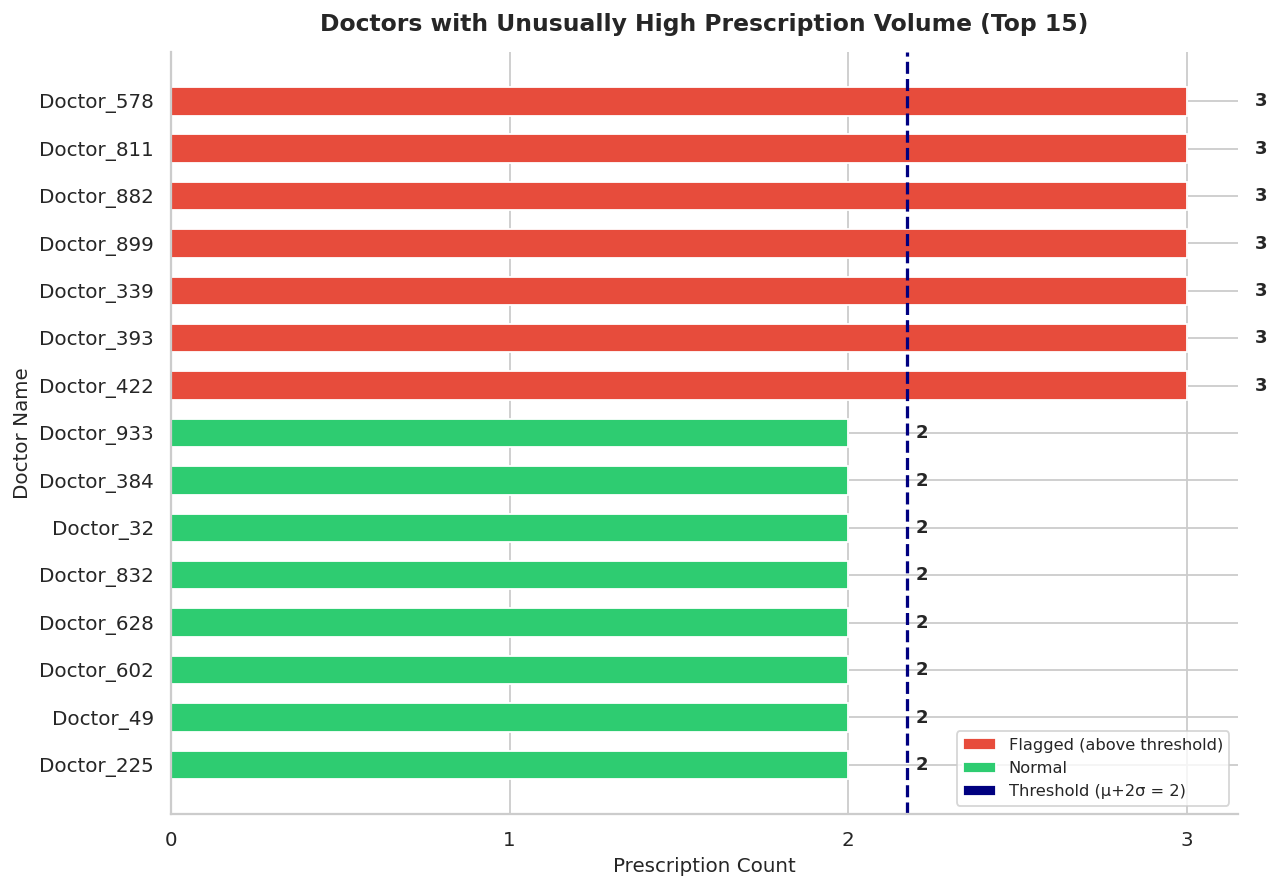

Flagged doctors (threshold = 2):
  Doctor_578 → 3
  Doctor_811 → 3
  Doctor_882 → 3
  Doctor_899 → 3
  Doctor_339 → 3
  Doctor_393 → 3
  Doctor_422 → 3


In [19]:
# Cell 14 – Insight 5: Outlier Doctors (Top 15)
doc_all   = rx['doctor_name'].value_counts()
threshold = doc_all.mean() + 2 * doc_all.std()
top15     = doc_all.head(15)
colors    = ['#e74c3c' if v > threshold else '#2ecc71' for v in top15.values]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(top15.index[::-1], top15.values[::-1],
               color=colors[::-1], edgecolor='white', height=0.6)

for bar, val in zip(bars, top15.values[::-1]):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', fontsize=10, fontweight='bold')

ax.axvline(threshold, color='navy', linestyle='--', linewidth=1.8)

legend_elements = [
    Patch(facecolor='#e74c3c', label='Flagged (above threshold)'),
    Patch(facecolor='#2ecc71', label='Normal'),
    Patch(facecolor='navy',    label=f'Threshold (μ+2σ = {threshold:.0f})'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

ax.set_xlabel("Prescription Count", fontsize=11)
ax.set_ylabel("Doctor Name", fontsize=11)
ax.set_title("Doctors with Unusually High Prescription Volume (Top 15)",
             fontsize=13, fontweight='bold', pad=12)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.savefig("insight5_outlier_doctors.png")
plt.show()

flagged = doc_all[doc_all > threshold]
if not flagged.empty:
    print(f"Flagged doctors (threshold = {threshold:.0f}):")
    for doc, cnt in flagged.items():
        print(f"  {doc} → {cnt}")
else:
    print("No doctors flagged.")

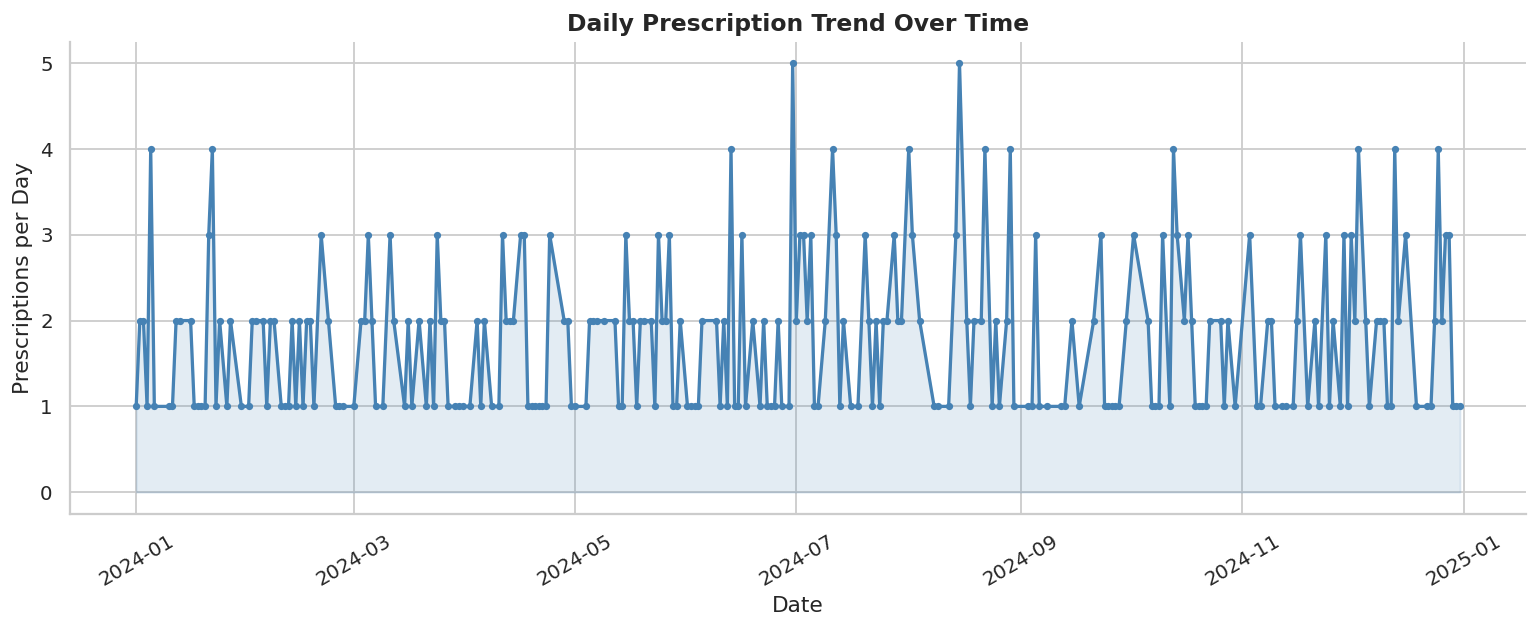

In [20]:
# Cell 15 – Insight 6: Daily Prescription Trend
daily = rx.groupby('prescribed_date').size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(daily['prescribed_date'], daily['count'],
        color='steelblue', linewidth=1.8, marker='o', markersize=3)
ax.fill_between(daily['prescribed_date'], daily['count'], alpha=0.15, color='steelblue')
ax.set_xlabel("Date")
ax.set_ylabel("Prescriptions per Day")
ax.set_title("Daily Prescription Trend Over Time", fontsize=13, fontweight='bold')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.savefig("insight6_daily_trend.png")
plt.show()

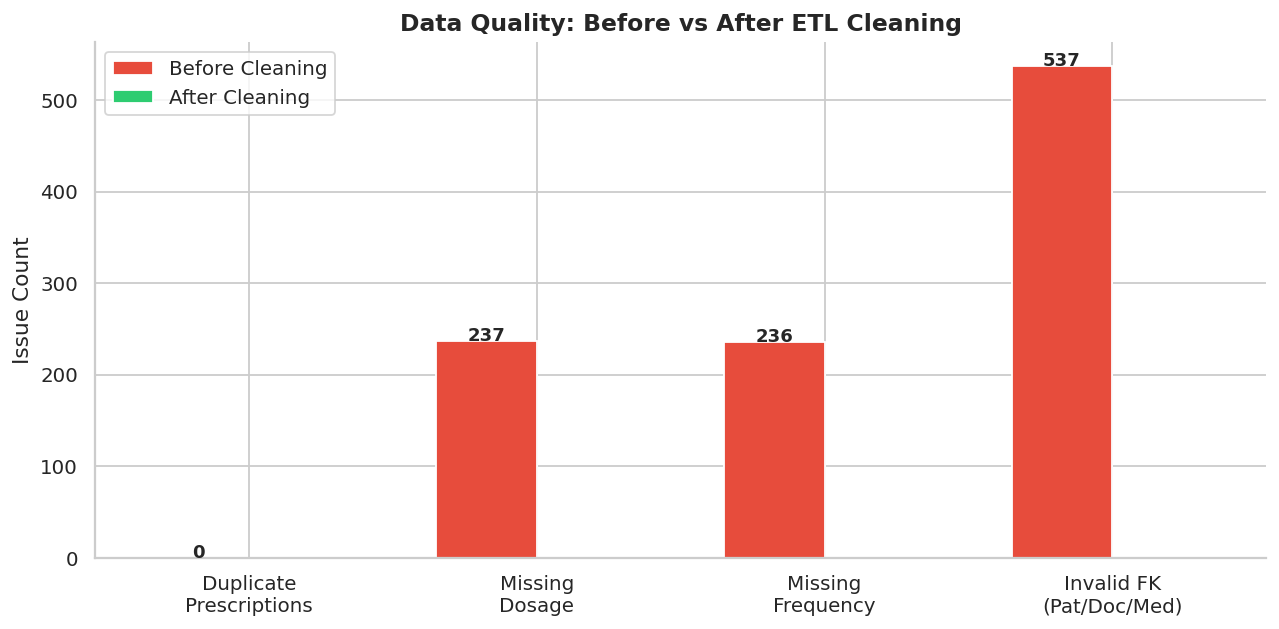

Total issues before : 1010
Total issues after  : 0
Clean records loaded: 463


In [21]:
# Cell 16 – Insight 7: Data Quality Before vs After
raw_rx = raw_prescriptions.copy()

raw_dup    = raw_rx.duplicated(subset=['prescription_id']).sum()
raw_dosage = raw_rx['dosage'].isna().sum()
raw_freq   = raw_rx['frequency'].isna().sum()
raw_fk     = pre_fk - len(prescriptions)

categories  = ['Duplicate\nPrescriptions', 'Missing\nDosage',
               'Missing\nFrequency', 'Invalid FK\n(Pat/Doc/Med)']
before_vals = [raw_dup, raw_dosage, raw_freq, raw_fk]
after_vals  = [0, 0, 0, 0]

x     = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
b1 = ax.bar(x - width/2, before_vals, width, label='Before Cleaning',
            color='#e74c3c', edgecolor='white')
ax.bar(x + width/2, after_vals, width, label='After Cleaning',
       color='#2ecc71', edgecolor='white')

for bar, val in zip(b1, before_vals):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
            str(val), ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel("Issue Count")
ax.set_title("Data Quality: Before vs After ETL Cleaning", fontsize=13, fontweight='bold')
ax.legend()
sns.despine()
plt.tight_layout()
plt.savefig("insight7_data_quality.png")
plt.show()

print(f"Total issues before : {sum(before_vals)}")
print(f"Total issues after  : 0")
print(f"Clean records loaded: {len(prescriptions)}")